<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City)_

#### Learning Objectives
- Define data modeling and simple linear regression.
- Build a linear regression model using a data set that meets the linearity assumption using the scikit-learn library.
- Understand and identify multicollinearity in a multiple regression.

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the Bikeshare Data Set
---

We are going to use bikeshare data to build a simple demand forecasting model.

**Possible applications:**

* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [2]:
# Read the data and set the datetime as the index.
url = '../data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [3]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=No

In [4]:
# Preview the first five rows of the DataFrame.
# /scrub/
bikes.head()

season  holiday  workingday  weather  temp   atemp  humidity  \
datetime                                                                   
2011-01-01       1        0           0        1  3.28  3.0014        81   
2011-01-01       1        0           0        1  2.34  1.9982        80   
2011-01-01       1        0           0        1  2.34  1.9982        80   
2011-01-01       1        0           0        1  3.28  3.0014        75   
2011-01-01       1        0           0        1  3.28  3.0014        75   

            windspeed  casual  registered  count  
datetime                                          
2011-01-01        0.0       3          13     16  
2011-01-01        0.0       8          32     40  
2011-01-01        0.0       5          27     32  
2011-01-01        0.0       3          10     13  
2011-01-01        0.0       0           1      1

#### What does each observation (row) represent?

/scrub/

Each observation is an hour of events.

`num_total_users` indicates the total number of riders. It will be the target variable that we try to forecast.

#### How many features are there?

Don't num_total_users "num_casual_users" or "num_registered_users" -- they are segments of the total users, so they are alternative target variables  that aren't available for forecasting total users.

/scrub/

9

#### Data dictionary

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1 = spring, 2 = summer, 3 = fall, 4 = winter |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| 1: Clear, 2: Mist, 3: Light Rain or Snow 4: Heavy Rain or Snow|
|temp| temp_celsius in Celsius|
|atemp| "feels like" temp_celsius in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-num_registered_users user rentals initiated|
|registered| number of num_registered_users user rentals initiated|
|count| number of total rentals|

#### Exercise:

Rename the columns in `bikes` as indicated below.

| old name | new name |
| ---    | --- |
| temp | temp_celsius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent
| count | num_total_users

Using these more explicit names will make it easier to avoid mistakes.

In [5]:
# /scrub/
bikes.rename(columns={'temp':'temp_celsius',
                      'atemp':'atemp_celsius',
                      'windspeed': 'windspeed_knots',
                      'casual': 'num_casual_users',
                      'registered': 'num_registered_users',
                      'season': 'season_num',
                      'holiday': 'is_holiday',
                      'workingday': 'is_workingday',
                      'humidity': 'humidity_percent',
                      'count': 'num_total_users'
                      },
             inplace=True
             )

In [6]:
bikes

season_num  is_holiday  is_workingday  weather  temp_celsius  \
datetime                                                                   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        1          2.34   
2011-01-01           1           0              0        1          2.34   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        2          3.28   
2011-01-01           1           0              0        1          2.34   
2011-01-01           1           0              0        1          1.40   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        1          7.04   
2011-01-01           1           0              0        1          9.86   
2011-01-01           1           0              0        1          8.92   
2011-01-01           1           0              0        1         11.74   
2011-01-01           1           0              0        2         13.62   
2011-01-01           1           0              0        2         13.62   
2011-01-01           1           0              0        2         12.68   
2011-01-01           1           0              0        2         11.74   
2011-01-01           1           0              0        2         12.68   
2011-01-01           1           0              0        3         11.74   
2011-01-01           1           0              0        3         11.74   
2011-01-01           1           0              0        2         10.80   
2011-01-01           1           0              0        2         10.80   
2011-01-01           1           0              0        2         10.80   
2011-01-01           1           0              0        2         13.62   
2011-01-02           1           0              0        2         13.62   
2011-01-02           1           0              0        2         12.68   
2011-01-02           1           0              0        2         11.74   
2011-01-02           1           0              0        2         13.62   
2011-01-02           1           0              0        2         13.62   
2011-01-02           1           0              0        3         11.74   
...                ...         ...            ...      ...           ...   
2012-12-30           1           0              0        2          3.28   
2012-12-30           1           0              0        1          7.98   
2012-12-30           1           0              0        1          2.34   
2012-12-30           1           0              0        1          1.40   
2012-12-30           1           0              0        1          1.40   
2012-12-30           1           0              0        1          1.40   
2012-12-31           1           0              1        1          0.46   
2012-12-31           1           0              1        1          0.46   
2012-12-31           1           0              1        1         -0.48   
2012-12-31           1           0              1        1         -0.48   
2012-12-31           1           0              1        1         -1.42   
2012-12-31           1           0              1        1         -0.48   
2012-12-31           1           0              1        1         -0.48   
2012-12-31           1           0              1        1         -0.48   
2012-12-31           1           0              1        1         -1.42   
2012-12-31           1           0              1        2          0.46   
2012-12-31           1           0              1        2          1.40   
2012-12-31           1           0              1        2          2.34   
2012-12-31           1           0              1        2          3.28   
2012-12-31           1           0              1        2  

<a id="visualizing-the-data"></a>
### Visualizing the Data

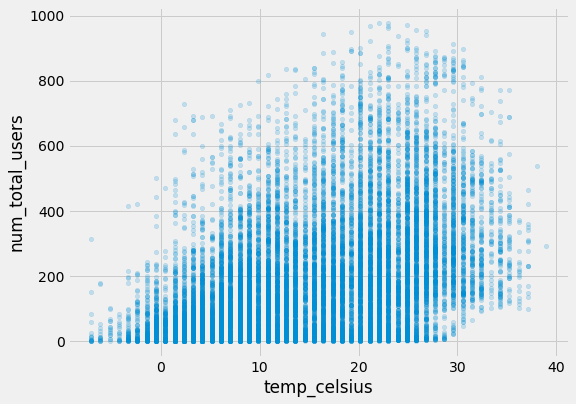

In [7]:
# Pandas scatterplot
# /scrub/
bikes.plot(kind='scatter', x='temp_celsius', y='num_total_users', alpha=0.2);

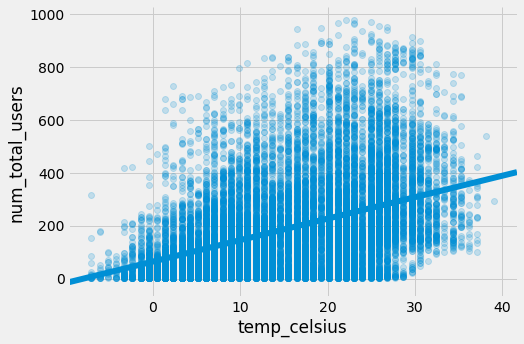

In [8]:
# Seaborn scatterplot with regression line
# /scrub/
sns.lmplot(x='temp_celsius',
           y='num_total_users',
           data=bikes,
           aspect=1.5, # aspect ratio (width:height)
           scatter_kws={'alpha':0.2}
           );

We just created a linear regression model!

- **Formula for a line:** $y = mx + b$
- **Our model:** $\mbox{num_total_users} = \alpha * \mbox{temp_celsius} + \beta$

We call $\alpha$ the **coefficient** of `temp_celsius` and $\beta$ the **model intercept**.

**Exercise.** Answer each question with an expression that includes one or more symbols, rather than an exact number. The symbol $\alpha$ is called "alpha," and the symbol $\beta$ is called "beta."

- What would our model predict for `num_total_users` at `temp_celsius=0`?

/scrub/

$\beta$

- If `temp_celsius` increases by 5, how does our model's prediction for `num_total_users` change? What if $\alpha$ were negative?

/scrub/

It increases by $5*\alpha$. If $\alpha$ were negative, then it would decrease by $5 * |\alpha|$.

- I claim that this model does *not* tell us how the number of total uses would change if we were (somehow) to intervene to increase $temp\_celsius$ by 5. Why not?

/scrub/

The model is not causal. It could be that, e.g., the bikes are used more during the summer because there are tourists during that time. In this scenario, the relationship between temp and usage is confounded by season, which introduces bias into naive inferences from correlation to causation.

Linear regression with one input feature chooses the *line* that "best fits" a scatterplot of the target variable against that input feature.

# Building a Linear Regression Models with scikit-learn

scikit-learn is the most popular Python library for machine learning.

**Strengths:**

- Includes good implementations of a wide range of algorithms.
- Interface is consistent across model types.
- Documentation is excellent.
- Large community --> tons of resources for learning and getting questions answered.

**Limitations:**

- Deep learning capabilites are very basic.
- Reflects machine learning rather than statistics mindset: focuses on predictive accuracy on held-out data rather than hypothesis testing, parameter estimation, and model interpretation.

In [9]:
# Import the LinearRegression model class
# /scrub/
from sklearn.linear_model import LinearRegression

In [10]:
# Make an instance of the LinearRegression class.
# /scrub/
lr_celsius = LinearRegression()
type(lr_celsius)

sklearn.linear_model.base.LinearRegression

In [11]:
# Train the model instance on our data, using just temp_celsius for now
# /scrub/
X = bikes.loc[:, ['temp_celsius']] # scikit-learn expects 2d features
y = bikes.loc[:, 'num_total_users']
lr_celsius.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# Add the fitted values to our DataFrame
# /scrub/
bikes.loc[:, 'predictions'] = lr_celsius.predict(X)

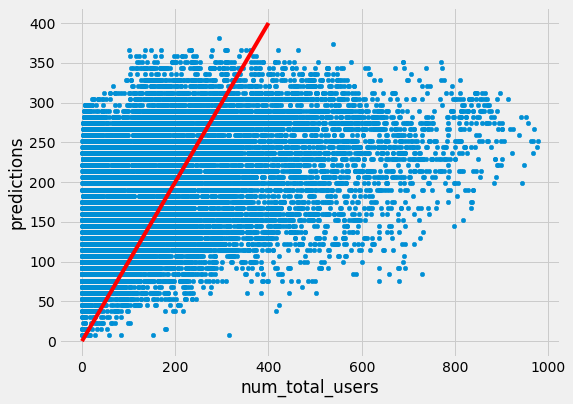

In [13]:
# Compare fitted values to actual
# /scrub/
fig, ax = plt.subplots()
bikes.plot(kind='scatter', x='num_total_users', y='predictions', ax=ax)
ax.plot([0, 400], [0, 400], 'r')

In [14]:
bikes.drop('predictions', axis=1, inplace=True)

<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

1. Import the class you plan to use.
2. "Instantiate" the class. You can specify "hyperparameters" at this point.
3. Fit the model instance with data. (This step changes the model object in-place.)
4. Use the fitted model to make predictions.

### Exercise

Build another linear regression model, this time using all of our features as inputs instead of just `temp_celsius`.

- Store a pandas DataFrame with the values of the feature variables (everything except `num_casual_users`, and `num_total_users`) as a Python variable X.

In [15]:
# /scrub/
bikes.columns

Index(['season_num', 'is_holiday', 'is_workingday', 'weather', 'temp_celsius',
       'atemp_celsius', 'humidity_percent', 'windspeed_knots',
       'num_casual_users', 'num_registered_users', 'num_total_users'],
      dtype='object')

In [16]:
# /scrub/
X = bikes.loc[:, ['season_num',
                 'is_holiday',
                 'is_workingday',
                 'weather',
                 'temp_celsius',
                 'atemp_celsius',
                 'humidity_percent',
                 'windspeed_knots']]

- Run the cell below to check your work.

In [17]:
# Tests
assert isinstance(y, pd.Series)
assert isinstance(X, pd.DataFrame)
assert y.shape[0] == bikes.shape[0]
assert X.shape == (bikes.shape[0], bikes.shape[1] - 3)

- Make a new instance of the LinearRegression class. Call it lr_all to distinguish it from our last model.

In [18]:
# /scrub/
lr_all = LinearRegression()

- Train the model instance using our new feature matrix $X$ and the same target variable $y$.

In [19]:
# /scrub/
lr_all.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Store `lr_all`'s fitted values in a new `predictions` column of the `bikes` DataFrame.

In [20]:
# /scrub/
bikes.loc[:, 'predictions'] = lr_all.predict(X)

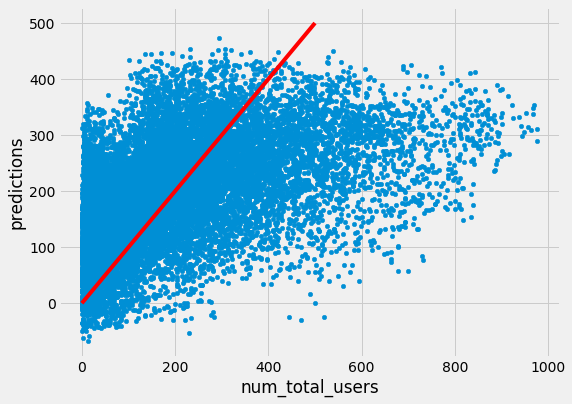

In [21]:
# Compare predicted values to actual
fig, ax = plt.subplots()
bikes.plot(kind='scatter', x='num_total_users', y='predictions', ax=ax)
ax.plot([0, 500], [0, 500], 'r')

In [22]:
bikes.drop('predictions', axis=1, inplace=True)

The plot above shows how well the model fits the data it was trained on. How well it would predict new data that it wasn't trained on is a further issue.

# Linear Regression with Multiple Features

In [23]:
X.columns

Index(['season_num', 'is_holiday', 'is_workingday', 'weather', 'temp_celsius',
       'atemp_celsius', 'humidity_percent', 'windspeed_knots'],
      dtype='object')

- **Our first model:**
    - **$y=mx+b$ notation:**
       - $\mbox{num_total_users} = \alpha * \mbox{temp_celsius} + \beta$
    - **New notation:**
       - $\mbox{num_total_users} = \beta_0 +  \beta_1 * \mbox{temp_celsius}$
- **Our second model:**
    - $\mbox{num_total_users} = \beta_0 + \beta_1 * \mbox{season_num} + \beta_2 * \mbox{is_holiday} + \beta_3 * \mbox{is_workingday} + \beta_4 * \mbox{weather} + \beta_5 * \mbox{temp_celsius} + \beta_6 * \mbox{atemp_celsius} + \beta_7 * \mbox{humidity_percent} + \beta_8 * \mbox{windspeed_knots}$

**Exercise.** Answer each question with an expression that includes one or more symbols, rather than an exact number. The symbol $\beta$ is called "beta."

- What would our model predict for `num_total_users` at with all input features 0?

/scrub/

$\beta_0$

- If `humidity_percent` decreases by 3 while all other features remain fixed, how does our model's prediction for `num_total_users` change?

/scrub/

It decreases by $3*humidity\_percent$.

- Why does the previous question say "while all other features remain fixed?"

/scrub/

`humidity_percent` might be correlated with temperature, for instance. In that case, a typical day with `humidity_percent` 60 would be warmer than a typical day with `humidity_percent` 57. The coefficient on `humidity_percent` doesn't reflect this relationship. It only reflects the influence of `humidity_percent` on the model's predictions *all else being equal*.

- What would it mean if a feature had a coefficient of 0?

/scrub/

It would mean that the feature made no difference to the model's predictions.

Linear regression with two input features chooses the "plane" that "best fits" a 3D scatterplot of the target variable against those input features.

In general, linear regression chooses the "hyperplane" that "best fits" a scatterplot of the target variable against the input features.

#### Explore the intercept and coefficients of the linear model

In [24]:
# Print the coefficients.
print(lr_all.intercept_)
print(lr_all.coef_)

216.09930303
[ 19.80244456 -21.83281619   3.31021316   8.51301983   1.4708144
   4.43306071  -3.04462961  52.92027726]


**Exercise.** How do the model's predictions change for a holiday vs. a non-holiday, all else being equal?

In [25]:
# /scrub/
X.columns

Index(['season_num', 'is_holiday', 'is_workingday', 'weather', 'temp_celsius',
       'atemp_celsius', 'humidity_percent', 'windspeed_knots'],
      dtype='object')

/scrub/

They decrease by 21.8

In [26]:
# Look at the documentation for a LinearRegression model object
# /scrub/
help(lr_all)

Help on LinearRegression in module sklearn.linear_model.base object:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin)
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False``.
 |  
 |  copy_X : boolean, optional, default True
 |      If True, X will be copied; else, it may be overwritten.
 |

# A Little Theory

Fitting a linear regression selects the coefficients and intercept that minimize the **sum of squared errors** of the fitted values on the training set.

![Estimating coefficients](../assets/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

**Justification:** Minimizing the sum of squared errors maximizes *the probability of the data given the model* (the **likelihood** of the model on the data) on the assumption that the target variable really is a linear function of the features plus normally distributed "noise:" $y = \beta_0 + \sum \beta_i x_i + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$

![](../assets/400px-Linear_regression.svg.png)

**Exercise.** In our second model, does it appear that the target variable is a linear function of the features plus normally distributed noise? Why or why not?

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](../assets/supervised_learning.png)

<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temp_celsius was measured in Fahrenheit, rather than Celsius. How would that affect our first model?

In [27]:
# Create a new column for Fahrenheit temp_celsius.
# /scrub/
bikes.loc[:, 'temp_fahrenheit'] = bikes.loc[:, 'temp_celsius'] * 1.8 + 32
bikes.head()

season_num  is_holiday  is_workingday  weather  temp_celsius  \
datetime                                                                   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        1          2.34   
2011-01-01           1           0              0        1          2.34   
2011-01-01           1           0              0        1          3.28   
2011-01-01           1           0              0        1          3.28   

            atemp_celsius  humidity_percent  windspeed_knots  \
datetime                                                       
2011-01-01         3.0014                81              0.0   
2011-01-01         1.9982                80              0.0   
2011-01-01         1.9982                80              0.0   
2011-01-01         3.0014                75              0.0   
2011-01-01         3.0014                75              0.0   

            num_casual_users  num_registered_users  num_total_users  \
datetime                                                              
2011-01-01                 3                    13               16   
2011-01-01                 8                    32               40   
2011-01-01                 5                    27               32   
2011-01-01                 3                    10               13   
2011-01-01                 0                     1                1   

            temp_fahrenheit  
datetime                     
2011-01-01           37.904  
2011-01-01           36.212  
2011-01-01           36.212  
2011-01-01           37.904  
2011-01-01           37.904

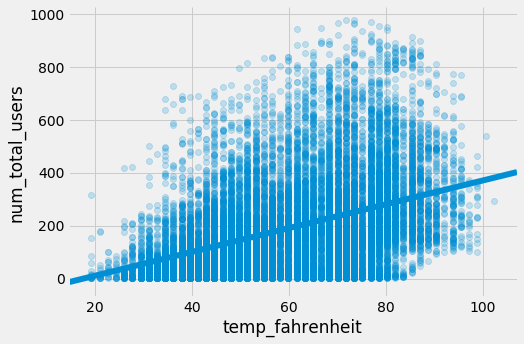

In [28]:
# Seaborn scatterplot with regression line
# /scrub/
sns.lmplot(x='temp_fahrenheit',
           y='num_total_users',
           data=bikes,
           aspect=1.5,
           scatter_kws={'alpha':0.2});

#### Rebuild the first model using temp_fahrenheit instead or temp_celsius.

In [29]:
# /scrub/
# Create X and y.
feature_cols = ['temp_fahrenheit']
X = bikes.loc[:, feature_cols]
y = bikes.loc[:, 'num_total_users']

# Instantiate and fit.
lr_fahrenheit = LinearRegression()
lr_fahrenheit.fit(X, y)

# Print the coefficients.
print(lr_fahrenheit.intercept_)
print(lr_fahrenheit.coef_)

-79.3593624455
[ 4.50703218]


#### Convert 25 degrees Celsius to Fahrenheit.

In [30]:
25 * 1.8 + 32

77.0

#### Predict rentals for 25 degree celsius and for 77 degrees Fahrenheit.

In [31]:
lr_celsius.predict(25)

array([ 267.68211526])

In [32]:
lr_fahrenheit.predict(77)

array([ 267.68211526])

**Conclusion:** The scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

In [33]:
# Remove the temp_fahrenheit column.
bikes.drop('temp_fahrenheit', axis=1, inplace=True)

<a id="visualizing-the-data-part-"></a>
### Exploring the Data

Throwing all of your data into a linear regression model is almost never a good approach. Let's inspect our data and come up with something smarter.

#### Explore a few features.

In [34]:
# Create feature column variables
feature_cols = ['temp_celsius', 'season_num', 'weather', 'humidity_percent']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the `y_vars` argument to only show relationships with the `num_total_users` variable

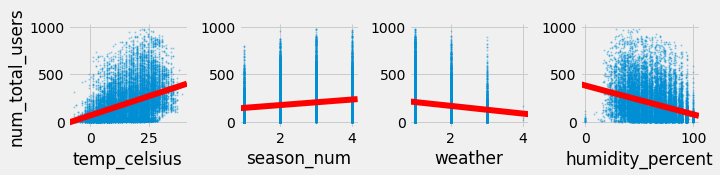

In [35]:
# Multiple scatterplots in Seaborn
sns.pairplot(bikes,
             x_vars=feature_cols,
             y_vars='num_total_users',
             kind='reg',
             plot_kws={'scatter_kws': {'s':1, 'alpha':.3},
                       'line_kws': {'color':'red'}
                       }
             );

**Exercise.**

/poll "Which is the best interpretation of the slope of the line for `num_total_users` against `humidity_percent`?" "How much a linear regression model's predictions for `num_total_users` against `humidity_percent` would change given a one-unit change in `humidity_percent`" "How much a linear regression model's predictions for `num_total_users` against `temp_celsius`, `season_num`, `weather`, and `humidity_percent` would change given a one-unit change in `humidity_percent`" "How much a linear regression model's predictions for `num_total_users` against `temp_celsius`, `season_num`, `weather`, and `humidity_percent` would change given a one-unit change in `humidity_percent`, holding all of those other variables constant"

#### Explore the season_num variable using a cross-tab.

In [36]:
# Cross-tabulation of season_num and month
# /scrub/
pd.crosstab(bikes.loc[:, 'season_num'], bikes.index.month)

col_0         1     2    3     4     5    6     7     8     9     10    11  \
season_num                                                                   
1           1429  1341  949     0     0    0     0     0     0     0     0   
2              0     0  524  1437  1488  960     0     0     0     0     0   
3              0     0    0     0     0  480  1488  1475  1053     0     0   
4              0     0    0     0     0    0     0     0   384  1451  1437   

col_0        12  
season_num       
1           523  
2             0  
3             0  
4           960

#### Explore the season_num variable using a box plot.

/Users/greg/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


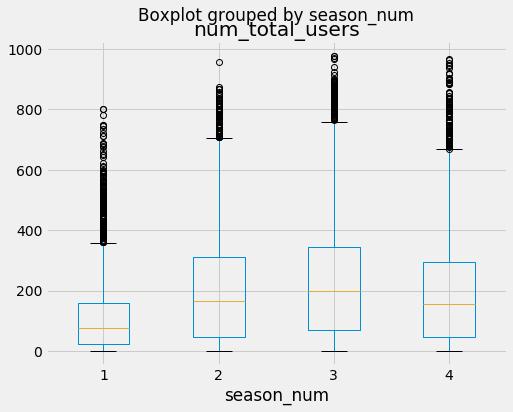

In [37]:
# Box plot of rentals, grouped by season_num.
# /scrub/
bikes.boxplot(column='num_total_users', by='season_num');

#### Look at rentals over time.

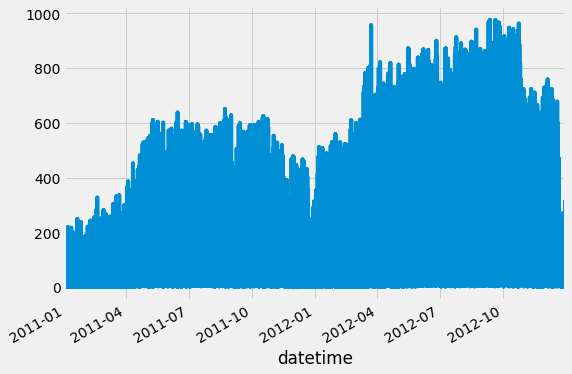

In [38]:
# Line plot of rentals
bikes.num_total_users.plot();

- **Trend:** System is generall growing over time.
- **Seasonality:** Periodic patterns in the data:
    - Yearly
    - Weekly
    - Daily

A good model will account for both.

#### Look at the correlation matrix for the bikes `DataFrame`.

In [39]:
# Correlation matrix (ranges from 1 to -1)
bikes.corr()

season_num  is_holiday  is_workingday   weather  \
season_num              1.000000   -0.009585       0.013743 -0.014524   
is_holiday             -0.009585    1.000000      -0.252471 -0.017036   
is_workingday           0.013743   -0.252471       1.000000  0.044672   
weather                -0.014524   -0.017036       0.044672  1.000000   
temp_celsius            0.312025   -0.027340       0.055390 -0.102640   
atemp_celsius           0.319380   -0.030973       0.054667 -0.105563   
humidity_percent        0.150378   -0.010665       0.015693  0.418137   
windspeed_knots        -0.149773    0.003988      -0.011830  0.026226   
num_casual_users        0.120206    0.031564      -0.300942 -0.152628   
num_registered_users    0.174226   -0.047345       0.134326 -0.120966   
num_total_users         0.178056   -0.030927       0.030284 -0.142426   

                      temp_celsius  atemp_celsius  humidity_percent  \
season_num                0.312025       0.319380          0.150378   
is_holiday               -0.027340      -0.030973         -0.010665   
is_workingday             0.055390       0.054667          0.015693   
weather                  -0.102640      -0.105563          0.418137   
temp_celsius              1.000000       0.987672         -0.070290   
atemp_celsius             0.987672       1.000000         -0.052324   
humidity_percent         -0.070290      -0.052324          1.000000   
windspeed_knots          -0.023125      -0.062336         -0.290014   
num_casual_users          0.459616       0.454080         -0.347124   
num_registered_users      0.335361       0.332559         -0.274133   
num_total_users           0.404772       0.400929         -0.323104   

                      windspeed_knots  num_casual_users  num_registered_users  \
season_num                  -0.149773          0.120206              0.174226   
is_holiday                   0.003988          0.031564             -0.047345   
is_workingday               -0.011830         -0.300942              0.134326   
weather                      0.026226         -0.152628             -0.120966   
temp_celsius                -0.023125          0.459616              0.335361   
atemp_celsius               -0.062336          0.454080              0.332559   
humidity_percent            -0.290014         -0.347124             -0.274133   
windspeed_knots              1.000000          0.090287              0.082321   
num_casual_users             0.090287          1.000000              0.506618   
num_registered_users         0.082321          0.506618              1.000000   
num_total_users              0.093234          0.694564              0.972151   

                      num_total_users  
season_num                   0.178056  
is_holiday                  -0.030927  
is_workingday                0.030284  
weather                     -0.142426  
temp_celsius                 0.404772  
atemp_celsius                0.400929  
humidity_percent            -0.323104  
windspeed_knots              0.093234  
num_casual_users             0.694564  
num_registered_users         0.972151  
num_total_users              1.000000

#### Use a heat map to make it easier to read the correlation matrix.

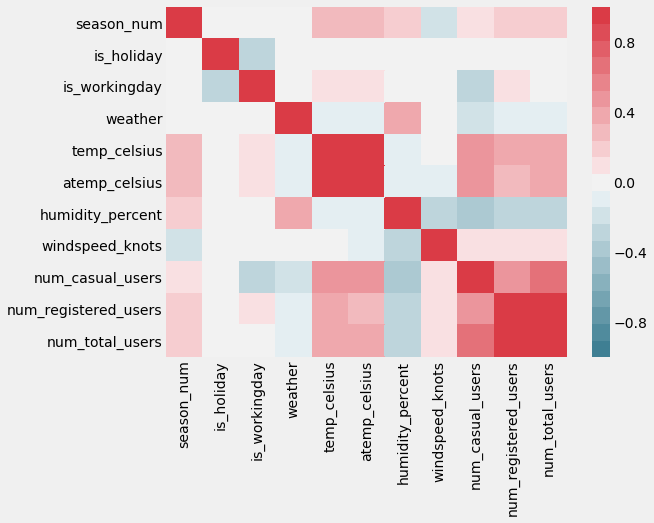

In [40]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes.corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            );

**Exercise.**

- We have two pairs of variables that are extremely strongly correlated. Which are they?

/scrub/

- `num_registered_users` and `num_total_users`
- `temp_celsius` and `atemp_celsius`

- Which features are positively correlated with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

/scrub/

`season_num`, `temp_celsius`, `atemp_celsius`

- Which features are negatively correlated with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

/scrub/

`weather` and `humidity_percent`

- Which features show very little correlation with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

/scrub/

`is_holiday` and `is_workingday`

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

We want features that are strongly correlated with the target and not with each other.

**Exercise.**

- Create another `LinearRegression` instance that is fit using `temp_celsius` and `atemp_celsius`, and print the coefficients.

In [72]:
# /scrub/
feature_cols = ['temp_celsius', 'atemp_celsius']

# Create X and y.
X = bikes.loc[:, feature_cols]
y = bikes.loc[:, 'num_total_users']

# Instantiate and fit.
lr_temp_atemp = LinearRegression()
lr_temp_atemp.fit(X, y)

# Print the coefficients.
print(lr_temp_atemp.coef_)

[ 7.18604592  0.74859391]


- Create another `LinearRegression` instance that is fit using `atemp_celsius` only, and print the coefficients.

In [73]:
# /scrub/
feature_cols = ['atemp_celsius']

# Create X and y.
X = bikes[feature_cols]
y = bikes.num_total_users

# Instantiate and fit.
lr_atemp = LinearRegression()
lr_atemp.fit(X, y)

# Print the coefficients.
print(lr_atemp.coef_)

[ 6.41182079]


- Why is the coefficient for `atemp` so different in the two models?

/scrub/

Remember how we interpret regression coefficients: the coefficient on `atemp` indicates how much the model's prediction increases when `atemp` is increased by one *holding all other features fixed*. Well, when you hold `temp` fixed, changes in `atemp` just reflect factors such as wind and humidity. When `temp` isn't in the model, it reflects temp itself as well.

This case is an example of *colinearity* (or *multicolinearity*).

<a id="what-is-multicollinearity"></a>
## What Is Colinearity?
---

Colinearity happens when two or more features are highly correlated with each other. It causes problems:

- Coefficients become hard to interpret
- Adding a variable to the model that is colinear with another variable in the model adds complexity while contributing limited new information, which can lead to overfitting.
- Model fitting can become numerically unstable.

## How to Select a Model

#### Recall: Model Bias and Variance

In [123]:
# Create a LOT of features
# /scrub/
from sklearn.preprocessing import PolynomialFeatures

X = (bikes.iloc[:2000, :]
     .loc[:, ['season_num',
              'is_holiday',
              'is_workingday',
              'weather',
              'temp_celsius',
              'atemp_celsius',
              'humidity_percent',
              'windspeed_knots']]
              )
pf = PolynomialFeatures(degree=6)
X = pf.fit_transform(X)
print(X.shape)

(2000, 3003)


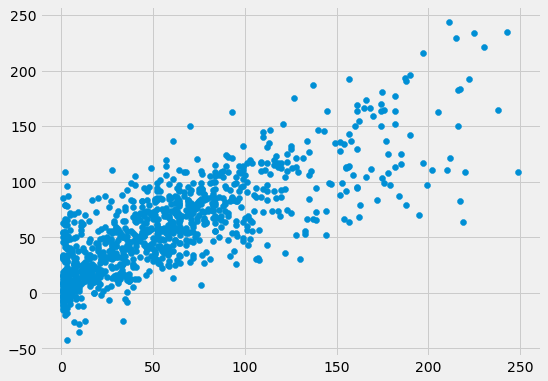

In [125]:
# Fit a model on the first 1000 rows and look at the fit
# /scrub/
lr_poly = LinearRegression()
lr_poly.fit(X[:1000], y.iloc[:1000])
plt.scatter(y.iloc[:1000], lr_poly.predict(X[:1000]))

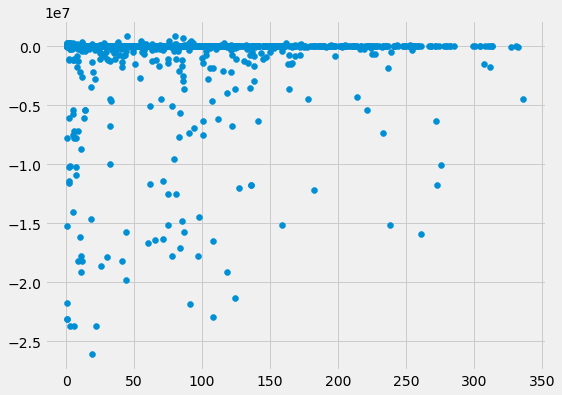

In [120]:
# See how the model does on the next 1000 rows
# /scrub/
plt.scatter(y.iloc[1001:2000], lr_poly.predict(X[1001:2000, :]))

**Moral 1:** Models that are too complicated for the sample size will fit the training data well but generalize poorly; this phenomenon is called **overfitting**.

**Exercise.**

- Does this overly complicated model have more of a bias problem or more of a variance problem?

**Moral 2:** If our primary concern is how well our model generalizes to new data, then we can evaluate it by seeing how it does on data that we hold out from the training set.

**Notes:**

- If you have a stats background then you might be used to using p-values to decide what variables to keep, or perhaps specialized model selection criteria such as adjusted R-squared, AIC, or BIC. But if what you really care about is predictive accuracy on data that the model hasn't seen before, then using a holdout set is much more direct.
- In a business context, you may sacrifice some predictive accuracy by using fewer input features for the sake of maintainability and computational performance.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Exercise.** Calculate MAE, MSE, and RMSE for the values below.

In [126]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [137]:
# Fill in these calculations. Hint: Turn the lists in numpy arrays.
mae = None
mse = None
rmse = None

# /scrub/

true = np.array(true)
pred = np.array(pred)
n = len(true)

mae = sum(abs(true - pred))/n
mse = sum((true - pred)**2)/n
rmse = np.sqrt(mse)

In [142]:
# Run this cell to check your answers.

from sklearn import metrics
print(mae)
print(mse)
print(rmse)
np.testing.assert_almost_equal(mae, metrics.mean_absolute_error(true, pred))
np.testing.assert_almost_equal(mse, metrics.mean_squared_error(true, pred))
np.testing.assert_almost_equal(rmse, np.sqrt(metrics.mean_squared_error(true, pred)))

2.0
7.5
2.73861278753


In [143]:
# Compare:
# /scrub/
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]
pred2 = [10, 7, 5, 13]
print(metrics.mean_absolute_error(true, pred), metrics.mean_squared_error(true, pred))
print(metrics.mean_absolute_error(true, pred2), metrics.mean_squared_error(true, pred2))

2.0 7.5
2.0 16.0


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, primary because the fact that it is continuous and differentiable makes it easier to work with.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
- MSE/MSE punishes large errors more than MAE.

<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [145]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
# /scrub/
def train_test_rmse(df, feature_cols):
    X = df.loc[:, feature_cols]
    y = df.loc[:, 'num_total_users']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [146]:
# Compare different sets of features.
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'weather', 'humidity_percent']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'weather']))
print(train_test_rmse(bikes, ['temp_celsius', 'season_num', 'humidity_percent']))

158.029161618
166.532973702
158.05455277


In [147]:
# Using these as features is not allowed!
print(train_test_rmse(bikes, ['num_casual_users', 'num_registered_users']))

1.74772264396e-13


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing RMSE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a baseline against which you may want to measure your regression model.

In [152]:
null_pred = y - np.mean(y)
null_rmse = np.sqrt(metrics.mean_squared_error(null_pred, y))
print(null_rmse)

189.463087635


<a id="handling-categorical-features"></a>
## Handling Categorical and Ordinal Features

**Exercise.**

We are representing `season` as follows:

1: winter
2: spring
3: summer
4: fall

- Suppose we fit linear regression model for ridership against season only and get a coefficient 10 for `season`. What does this coefficient imply about the relationship between predicted ridership for fall relative to summer? How could we get this result even though ridership is higher in summer than fall?

/scrub/

This coefficient implies that predicted ridership is higher for fall relative to summer by 10. We get this result even though ridership is higher in summer than fall because by ordering the seasons in the way that we have we are forcing the model predictions either to increase or to decrease from winter, to spring, to summer, to fall.

#### Dummy Coding

Here's a better representation:

- `is_spring`: 1 in spring, 0 otherwise
- `is_summer`: 1 in summer, 0 otherwise
- `is_fall`: 1 in fall, 0 otherwise

Instead of having one variable with 4 levels, we have 3 binary variables.

Our model now has three "degrees of freedom" to capture the impact of the season, instead of just one.

This process is called "dummy coding."

**Exercise**

1. Why is `is_winter` unnecessary?
2. In fact, why would including `is_winter` be harmful?
3. Suppose you build a model with these variables and find that the coefficient on `is_summer` is 30. What does that coefficient mean?
4. Could you use `is_winter`, `is_spring`, and `is_summer` instead? Why or why not? Is there any reason to prefer one set of dummy variables over another?

/scrub/

1. It's winter if and only if `is_spring`, `is_summer`, and `is_fall` are all 0, so `is_winter` would add no new information.
2. `is_winter` is completely colinear with `is_spring`, `is_summer`, and `is_fall` (`is_winter` = 3 - `is_spring` - `is_summer` - `is_fall`), so it would actually break the most straightforward algorithms for fitting linear regression.
3. A coefficient of 30 on `is_summer` means that all else being equal, the model predicts 30 more riders in summer than *in winter*.
4. Yes, you can drop any of the dummy variables for season. However, for interpreting your model it is helpful to drop the variable that is a natural "baseline" against which to compare the others.

In [206]:
# Dummy coding with pandas
# /scrub/
bikes_sample_seasons = bikes.loc[::1000, :]
dummies = pd.get_dummies(bikes_sample_seasons, columns=['season_num'])
pd.concat([bikes_sample_seasons.loc[:, 'season_num'],
           dummies.loc[:, [col for col in dummies.columns if col.startswith('season')]]],
          axis=1)

season_num  season_num_1  season_num_2  season_num_3  season_num_4
datetime                                                                      
2011-01-01           1             1             0             0             0
2011-02-14           1             1             0             0             0
2011-03-29           2             0             1             0             0
2011-05-09           2             0             1             0             0
2011-06-20           2             0             1             0             0
2011-08-01           3             0             0             1             0
2011-09-12           3             0             0             1             0
2011-10-24           4             0             0             0             1
2011-12-05           4             0             0             0             1
2012-01-15           1             1             0             0             0
2012-02-26           1             1             0             0             0
2012-04-08           2             0             1             0             0
2012-05-20           2             0             1             0             0
2012-06-30           3             0             0             1             0
2012-08-11           3             0             0             1             0
2012-09-22           3             0             0             1             0
2012-11-04           4             0             0             0             1
2012-12-16           4             0             0             0             1

In [208]:
# Drop a redundant column
dummies.drop('season_num_1', axis=1)

is_holiday  is_workingday  weather  temp_celsius  atemp_celsius  \
datetime                                                                      
2011-01-01           0              0        1          3.28         3.0014   
2011-02-14           0              1        1          9.86         9.9974   
2011-03-29           0              1        1          2.34        -2.0014   
2011-05-09           0              1        1         16.44        17.0000   
2011-06-20           0              1        1         23.02        24.9992   
2011-08-01           0              1        1         23.02        24.0026   
2011-09-12           0              1        1         26.78        28.0022   
2011-10-24           0              1        2          9.86         9.9974   
2011-12-05           0              1        1          7.04         5.9978   
2012-01-15           0              0        1         -0.48        -4.9978   
2012-02-26           0              0        1          8.92         7.0010   
2012-04-08           0              0        1         17.38        18.0032   
2012-05-20           0              0        1         15.50        15.9968   
2012-06-30           0              0        1         30.54        34.9982   
2012-08-11           0              0        1         29.60        32.9984   
2012-09-22           0              0        1         18.32        18.9998   
2012-11-04           0              0        1          7.04         5.9978   
2012-12-16           0              0        2          7.98         5.9978   

            humidity_percent  windspeed_knots  num_casual_users  \
datetime                                                          
2011-01-01                81           0.0000                 3   
2011-02-14                40           0.4627                 7   
2011-03-29                37           0.2537                 0   
2011-05-09                68           0.0896                21   
2011-06-20                61           0.1045                45   
2011-08-01                83           0.0896                 3   
2011-09-12                51           0.1642                60   
2011-10-24                94           0.1045                11   
2011-12-05                87           0.0896                 3   
2012-01-15                40           0.1642                 1   
2012-02-26                32           0.2239                46   
2012-04-08                24           0.2537               198   
2012-05-20                72           0.1045                 1   
2012-06-30                52           0.1642                48   
2012-08-11                49           0.3582               228   
2012-09-22                83           0.3284                 2   
2012-11-04                53           0.0000                56   
2012-12-16                87           0.1940                 1   

            num_registered_users  num_total_users  hour  daytime  \
datetime                                                           
2011-01-01                    13               16     0        0   
2011-02-14                   249              256     0        0   
2011-03-29                     8                8     0        0   
2011-05-09                    95              116     0        0   
2011-06-20                   130              175     0        0   
2011-08-01                    97              100     0        0   
2011-09-12                   129              189     0        0   
2011-10-24                   274              285     0        0   
2011-12-05                    21               24     0        0   
2012-01-15                    71               72     0        0   
2012-02-26                   241              287     0        0   
2012-04-08                   259              457     0        0   
2012-05-20                     7                8     0        0   
2012-06-30                   165              213     0        0   
20

Unlike `season`, our variable `weather` is at least ordinal:

1: Clear, 2: Mist, 3: Light Rain or Snow 4: Heavy Rain or Snow

However, there's no reason to assume that the difference between Clear and Mist has the same impact on ridership as the difference between Mist and List Rain/Snow or the difference between Light Rain/Snow and Heavy Rain/Snow. Here too our model can benefit from the additional degrees of freedom that dummy coding provides.

**Exercise** Use pandas to create dummy columns for `weather`, and drop the column that you want to use as a baseline.

In [210]:
# /scrub/
pd.get_dummies(bikes, columns=['weather']).drop('weather_1', axis=1)

season_num  is_holiday  is_workingday  temp_celsius  \
datetime                                                          
2011-01-01           1           0              0          3.28   
2011-01-01           1           0              0          2.34   
2011-01-01           1           0              0          2.34   
2011-01-01           1           0              0          3.28   
2011-01-01           1           0              0          3.28   
2011-01-01           1           0              0          3.28   
2011-01-01           1           0              0          2.34   
2011-01-01           1           0              0          1.40   
2011-01-01           1           0              0          3.28   
2011-01-01           1           0              0          7.04   
2011-01-01           1           0              0          9.86   
2011-01-01           1           0              0          8.92   
2011-01-01           1           0              0         11.74   
2011-01-01           1           0              0         13.62   
2011-01-01           1           0              0         13.62   
2011-01-01           1           0              0         12.68   
2011-01-01           1           0              0         11.74   
2011-01-01           1           0              0         12.68   
2011-01-01           1           0              0         11.74   
2011-01-01           1           0              0         11.74   
2011-01-01           1           0              0         10.80   
2011-01-01           1           0              0         10.80   
2011-01-01           1           0              0         10.80   
2011-01-01           1           0              0         13.62   
2011-01-02           1           0              0         13.62   
2011-01-02           1           0              0         12.68   
2011-01-02           1           0              0         11.74   
2011-01-02           1           0              0         13.62   
2011-01-02           1           0              0         13.62   
2011-01-02           1           0              0         11.74   
...                ...         ...            ...           ...   
2012-12-30           1           0              0          3.28   
2012-12-30           1           0              0          7.98   
2012-12-30           1           0              0          2.34   
2012-12-30           1           0              0          1.40   
2012-12-30           1           0              0          1.40   
2012-12-30           1           0              0          1.40   
2012-12-31           1           0              1          0.46   
2012-12-31           1           0              1          0.46   
2012-12-31           1           0              1         -0.48   
2012-12-31           1           0              1         -0.48   
2012-12-31           1           0              1         -1.42   
2012-12-31           1           0              1         -0.48   
2012-12-31           1           0              1         -0.48   
2012-12-31           1           0              1         -0.48   
2012-12-31           1           0              1         -1.42   
2012-12-31           1           0              1          0.46   
2012-12-31           1           0              1          1.40   
2012-12-31           1           0              1          2.34   
2012-12-31           1           0              1          3.28   
2012-12-31           1           0              1          4.22   
2012-12-31           1           0              1          5.16   
2012-12-31           1           0              1          5.16   
2012-12-31           1           0              1          4.22   
2012-12-31           1           0              1          4.22   
2012-12-31           1           0              1          4.22   
2012-12-31           1           0              1          4.22   
2012-12-31           1           0              1          

In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [60]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes, season_num_dummies], axis=1)

# Print five random rows.
bikes_dummies.sample(n=5, random_state=1)

season_num  is_holiday  is_workingday  weather  temp_celsius  \
datetime                                                                   
2012-10-19           4           0              1        2         17.38   
2011-05-13           2           0              1        2         16.44   
2011-03-15           1           0              1        2          7.98   
2012-03-20           1           0              1        1         17.38   
2012-09-06           3           0              1        3         24.90   

            atemp_celsius  humidity_percent  windspeed_knots  \
datetime                                                       
2012-10-19        18.0032                94           0.1045   
2011-05-13        17.0000                83           0.1642   
2011-03-15         5.0012                71           0.2836   
2012-03-20        18.0032                77           0.0000   
2012-09-06        28.0022                84           0.1642   

            num_casual_users  num_registered_users  num_total_users  \
datetime                                                              
2012-10-19                26                   363              389   
2011-05-13                56                    90              146   
2011-03-15                14                   138              152   
2012-03-20                32                   156              188   
2012-09-06                10                    52               62   

            season_num_2  season_num_3  season_num_4  
datetime                                              
2012-10-19             0             0             1  
2011-05-13             1             0             0  
2011-03-15             0             0             0  
2012-03-20             0             0             0  
2012-09-06             0             1             0

#### Rerun the linear regression with dummy variables included.

In [61]:
# Include dummy variables for season_num in the model.
feature_cols = ['temp_celsius', 'season_num_2', 'season_num_3', 'season_num_4', 'humidity_percent']
X = bikes_dummies[feature_cols]
y = bikes_dummies.num_total_users

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(feature_cols, linreg.coef_))

[('temp_celsius', 9.7141966124817305),
 ('season_num_2', -1.9124011354723205),
 ('season_num_3', -46.365626853536014),
 ('season_num_4', 55.501887315183467),
 ('humidity_percent', -2.840686532603339)]

How do we interpret the season_num coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season_num was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [62]:
# Compare original season_num variable with dummy variables.
print(train_test_rmse(bikes_dummies, ['temp_celsius', 'season_num', 'humidity_percent']))
print(train_test_rmse(bikes_dummies, ['temp_celsius', 'season_num_2', 'season_num_3', 'season_num_4', 'humidity_percent']))

158.05455277
156.630259842


<a id="feature-engineering"></a>
### Feature Engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature.

In [63]:
bikes['hour'] = bikes.index.hour

#### Encode `hour` as a categorical feature.

In [64]:
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([bikes, hour_dummies], axis=1)

#### Generate a `daytime` variable based on hour of the day.

In [65]:
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

#### Test the root mean squared error of our various `hour` encodings.

In [66]:
print(train_test_rmse(bikes, ['hour']))
print(train_test_rmse(bikes, bikes.columns[bikes.columns.str.startswith('hour_')]))
print(train_test_rmse(bikes, ['daytime']))

182.377294898


ValueError: Found array with 0 feature(s) (shape=(13034, 0)) while a minimum of 1 is required.

<a id="bonus-material-regularization"></a>
## Bonus Material: Regularization
---

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](../assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
# Include dummy variables for season_num in the model.
feature_cols = ['temp_celsius', 'atemp_celsius', 'season_num_2', 'season_num_3', 'season_num_4', 'humidity_percent']
X = bikes_dummies[feature_cols]
y = bikes_dummies.num_total_users

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [ ]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

While the MSE barely improved, we can see there are significant changes in the weight of our coefficients.  Particularly `season_num_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.